# AIAIART #4 - Going Further

![we made it GIF](https://c.tenor.com/prsoqBBB5pkAAAAM/happy-homer.gif)

We've made it! This is the final lesson in our short course. 

This notebook will be slightly different to the others in that it is more of a series of shorter demos showing ways you can use what we've learnt in the previous lessons in different ways. I've tried to keep it modular so that you can run the sections individually and use these as templates for different projects.

The downloads section can be run once per session, the setup should be run after every restart and then after that each section should work independant of the others. 

In [ ]:
#@title Lesson 4 Video (Live Recording)
from IPython import display as ipd
html = ipd.display(ipd.HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/Uio8PJcyd1k" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'))
html

# Downloads (run once)

In [1]:
#@title CLIP download
print("Downloading CLIP and installing requirements")
!git clone https://github.com/openai/CLIP                 &> /dev/null
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning &> /dev/null

In [2]:
# @title VQGAN Download
print('Downloading ImageNet 16384 checkpoints for VQGAN')
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt

print('Installing a few libraries for VQGAN')
!git clone https://github.com/CompVis/taming-transformers &> /dev/null
!pip install einops                                       &> /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100   692  100   692    0     0    543      0  0:00:01  0:00:01 --:--:-- 86500
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  10.1M      0  0:01:32  0:01:32 --:--:-- 9883k
Installing a few libraries for VQGAN


# Setup

In [1]:
#@title Imports and useful functions
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob, os
import cv2
import IPython.display as ipd
from omegaconf import OmegaConf
import sys
sys.path.append('./taming-transformers')
from taming.models import cond_transformer, vqgan


import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from tqdm.notebook import tqdm

from CLIP import clip # The clip model
from torchvision import transforms # Some useful image transforms
import torch.nn.functional as F # Some extra methods we might need
from tqdm.notebook import tqdm # A progress bar library


def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply

def vector_quantize(x, codebook):
  d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
  indices = d.argmin(-1)
  x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
  return replace_grad(x_q, x)

def synth(z):
  z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
  return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

def rand_z(width, height):
  f = 2**(model.decoder.num_resolutions - 1)
  toksX, toksY = width // f, height // f
  n_toks = model.quantize.n_e
  one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
  z = one_hot @ model.quantize.embedding.weight
  z = z.view([-1, toksY, toksX, model.quantize.e_dim]).permute(0, 3, 1, 2)
  return z


# Create a transform - this will map the image data to the same range as that seen by CLIP during training
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])


def clip_loss(im_embed, text_embed):
  im_normed = F.normalize(im_embed.unsqueeze(1), dim=2)
  text_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
  dists = im_normed.sub(text_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
  return dists.mean()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# A convenience function for going from a PIL image to a tensor:
def pil_to_torch(im):
  return torch.tensor(np.array(im)/255., dtype=torch.float).permute(2, 0, 1)[:3,:,:].unsqueeze(0)

In [4]:
#@title ImStack Class
class ImStack(nn.Module):
  """ This class represents an image as a series of stacked arrays, where each is 1/2
  the resolution of the next. This is useful eg when trying to create an image to minimise
  some loss - parameters in the early (small) layers can have an affect on the overall 
  structure and shapes while those in later layers act as residuals and fill in fine detail.
  """

  def __init__(self, n_layers=3, base_size=32, scale=2,
               init_image=None, out_size=256, decay=0.7, scale_mode='bilinear'):
    """Constructs the Image Stack

    Args:
        TODO
    """
    super().__init__()
    self.n_layers = n_layers
    self.base_size = base_size
    self.sig = nn.Sigmoid()
    self.layers = []

    for i in range(n_layers):
        side = base_size * (scale**i)
        # tim = torch.randn((3, side, side)).to(device)*(decay**i)
        tim = (torch.randn((3, side, side))*0.4).to(device)*(decay**i) 
        self.layers.append(tim)

    self.scalers = [nn.Upsample(scale_factor=out_size/(l.shape[1]), mode=scale_mode, align_corners=False) for l in self.layers]
    
    self.preview_scalers = [nn.Upsample(scale_factor=224/(l.shape[1]), mode=scale_mode, align_corners=False) for l in self.layers]
    
    if init_image != None: # Given a PIL image, decompose it into a stack
      downscalers = [nn.Upsample(scale_factor=(l.shape[1]/out_size), mode=scale_mode, align_corners=False) for l in self.layers]
      final_side = base_size * (scale ** n_layers)
      im = torch.tensor(np.array(init_image.resize((out_size, out_size)))/255).clip(1e-03, 1-1e-3).float()[:,:,:3] # Between 0 and 1 (non-inclusive)
      im = im.permute(2, 0, 1).unsqueeze(0).to(device) # torch.log(im/(1-im))
      for i in range(n_layers):self.layers[i] *= 0 # Sero out the layers
      for i in range(n_layers):
        side = base_size * (scale**i)
        out = self.forward()
        residual = (torch.logit(im) - torch.logit(out))
        Image.fromarray((torch.logit(residual).detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8)).save(f'residual{i}.png')
        self.layers[i] = downscalers[i](residual).squeeze()
    
    for l in self.layers: l.requires_grad = True

  def forward(self):
    im = self.scalers[0](self.layers[0].unsqueeze(0))
    for i in range(1, self.n_layers):
      im += self.scalers[i](self.layers[i].unsqueeze(0))
    return self.sig(im)

  def preview(self, n_preview=2):
    im = self.preview_scalers[0](self.layers[0].unsqueeze(0))
    for i in range(1, n_preview):
      im += self.preview_scalers[i](self.layers[i].unsqueeze(0))
    return self.sig(im)
  
  def to_pil(self):
    return Image.fromarray((self.forward().detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8))

  def preview_pil(self):
    return Image.fromarray((self.preview().detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8))

  def save(self, fn):
    self.to_pil().save(fn)

  def plot_layers(self):
    fig, axs = plt.subplots(1, self.n_layers, figsize=(15, 5))
    for i in range(self.n_layers):
      im = (self.sig(self.layers[i].unsqueeze(0)).detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8)
      axs[i].imshow(im)

In [5]:
#@title VGG16 Feature Extractor + Style Loss
from torchvision.models import vgg16 

# Ref: https://www.kaggle.com/danmoller/easy-style-transfer-with-pytorch

class VGGFeatureExtractor(nn.Module):
    def __init__(self, vggModel, layerIndices):
        super(VGGFeatureExtractor,self).__init__()
        self.features = vggModel.features
        
        #desired layers
        self.layerIndices = layerIndices
        self.outputCount = len(layerIndices)
        
        #making this model's parameters untrainble
        for p in self.parameters():
            p.requires_grad = False
        
    def forward(self,x):
        outputs = list()  #outputs from the selected layers
        
        #for each layer in the VGG
        for i, layer in enumerate(self.features.children()):
            x = layer(x) #apply the layer
            
            #if this layer is a desired layer, store its outputs
            if i in self.layerIndices:
                outputs.append(x)
                
                #check if we got all desired layers
                if i == self.layerIndices[-1]:
                    return outputs
                    
        return outputs

# Style and Content loss
def content_loss(im_content_features, target_content_features):
  loss = 0
  for im_features, target_features in zip(im_content_features, target_content_features):
    loss += nn.L1Loss()(im_features, target_features)
  return loss/len(im_content_features)

def gram(x):
	b,c,h,w = x.size();
	x = x.view(b*c, -1);
	return torch.mm(x, x.t())/(h*w) # /(h*w) normalizes by size to avoid over-focusing on early layers
 
def style_loss(im_style_features, target_style_features):
  loss = 0
  for im_features, target_features in zip(im_style_features, target_style_features):
    im_gram = gram(im_features)
    target_gram = gram(target_features)
    loss += F.mse_loss(im_gram, target_gram);
  return loss/len(im_style_features)

In [6]:
# Load the VQGAN model
model = load_vqgan_model('vqgan_imagenet_f16_16384.yaml', 'vqgan_imagenet_f16_16384.ckpt').to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


In [7]:
# Load CLIP
perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)

In [8]:
# Load VGG16 for style and content loss
vgg = vgg16(pretrained=True).to(device)
contentExtractor = VGGFeatureExtractor(vgg,  [15, 19])
styleExtractor = VGGFeatureExtractor(vgg,[5, 7, 10, 12, 17])

In [9]:
# The transforms to get variations of our image
tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

# GAN + Transforms

![spinning person](https://media3.giphy.com/media/enj50kao8gMfu/200w.gif?cid=82a1493bnk7ovq2fmifa0g3gs0oqqscve7lgskqo6cgonl8q&rid=200w.gif&ct=g)

Here we extend the GAN generation code from the previous lesson with one small addition. After some number of iterations have passed, we take the image, apply some transforms (in this case using PIL to zoom and rotate) and the re-encode that back into a new z which we continue to optimize.

There are many options you could try here - mess with the colours, shift it in some direction, add distortion, fisheye effect, overlay some weird shapes... go wild!

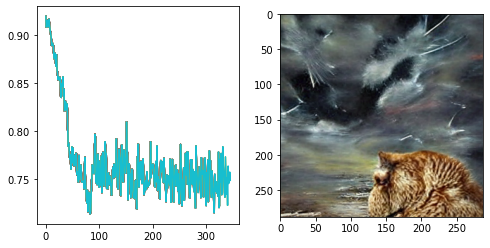

In [8]:
#@title Generating while zooming

prompt_text = "A cat, dramatic oil painting" #@param
transform_every =  5#@param
zoom =  8#@param
rotate = -1 #@param
start_transforms = 80 #@param
width = 300 #@param
height = 300 #@param
lr = 0.1 #@param
n_iter = 350 #@param
crops_per_iteration = 8 #@param

# The z we'll be optimizing
z = rand_z(width, height)
z.requires_grad=True

# The text target
text_embed = perceptor.encode_text(clip.tokenize(prompt_text).to(device)).float()

# The optimizer - feel free to try different ones here
optimizer = torch.optim.Adam([z], lr=lr, weight_decay=1e-6)

losses = [] # Keep track of our losses (RMSE values)

# A folder to save results
!rm -r steps
!mkdir steps


# Display for showing progress
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
p = display(fig, display_id=True)

# The optimization loop:
for i in tqdm(range(n_iter)):

  # Reset everything related to gradient calculations
  optimizer.zero_grad()

  # Get the GAN output
  output = synth(z)

  # Calculate our loss across several different random crops/transforms
  loss = 0
  for _ in range(crops_per_iteration):
    image_embed = perceptor.encode_image(tfms(normalize(output)).to(device)).float()
    loss += clip_loss(image_embed, text_embed)/crops_per_iteration

  # Store loss
  losses.append(loss.detach().item())

  # Backpropagate the loss and use it to update the parameters
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update

  # Update plots and save image
  if i % transform_every == 0:
    # Get image as array
    im_arr = np.array(output.cpu().squeeze().detach().permute(1, 2, 0)*255).astype(np.uint8)

    # Update plots
    axs[0].plot(losses)
    axs[1].imshow(im_arr)
    p.update(fig)

    # Save image
    Image.fromarray(im_arr).save(f'steps/{i//transform_every:04}.jpeg')


  if i > start_transforms and i%transform_every==0:
    # Apply some transforms
    im_arr = np.array(output.cpu().squeeze().detach().permute(1, 2, 0)*255).astype(np.uint8)
    pil_image = Image.fromarray(im_arr)
    sideX, sideY = pil_image.size
    im1 = pil_image.resize((sideX+zoom, sideY+zoom), Image.LANCZOS) # Zoom by adding zoom extra pixels
    im1 = im1.rotate(rotate) # Rotate by rotate degrees
    pil_image.paste(im1, (-zoom//2, -zoom//2)) # Paste this back over the original image

    # Re-encode this back into a new z to work with
    with torch.no_grad():
      z, *_ = model.encode(torch.tensor(np.array(pil_image)/255., dtype=torch.float).permute(2, 0, 1).unsqueeze(0).to(device) * 2 - 1)
      z.requires_grad = True
      optimizer = torch.optim.Adam([z], lr=lr, weight_decay=1e-6)

ipd.clear_output()

If you zoom too fast or don't give enough iterations per 'frame' (controlled by `transform_every`) you'll end up with some weird artifacts - this can be a fun thing to experiment with!

We can turn the images saved in the steps folder into a video with 

`
ffmpeg -v 0 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v h264_nvenc -preset slow -qp 18 -pix_fmt yuv420p progress_video.mp4
`



In [ ]:
#@title Show Video
!ffmpeg -v 0 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v h264_nvenc -preset slow -qp 18 -pix_fmt yuv420p progress_video.mp4
from IPython.display import HTML
from base64 import b64encode
mp4 = open('progress_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=300 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

此单元格的输出内容太大，只能在登录的情况下显示。


Another cool application is linking, say, the amount of rotation with a driving factor like audio. Here's an example:

In [ ]:
#@title Music Video Demo
HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/VtTU2NRbhc0?start=60" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

# Combining Loss Functions

![Combining powers GIF](https://media0.giphy.com/media/0Av9l0VIc01y1isrDw/giphy.gif)

Here we'll optimize an image (in this case using my ImStack class which you can learn more about here: https://colab.research.google.com/drive/1MCC2IwAaRNCTBUzghuG41ypAkxjJvGtq?usp=sharing)

As normal, we zero the gradients, get our image, calculate a loss and update the parameters used to generate the image. Except in this case, we calculate three components of the loss - style and content loss as in Lesson 2 and CLIP loss as in Lesson 3:



```
loss = content_weight*content_loss(im_content_features, target_content_features)
loss += style_weight * style_loss(im_style_features, target_style_features) 
image_embed = perceptor.encode_image(tfms(normalize(im)).to(device)).float()
loss += clip_weight*clip_loss(image_embed, text_embed)
```



Feel free to replace these images with your own!

In [ ]:
# Download a few images
!curl --output cat.jpeg "https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1" > /dev/null
!curl --output fire.jpeg "https://images.pexels.com/photos/207353/pexels-photo-207353.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1" > /dev/null

In [ ]:
#@title Combining different losses

!rm -r steps
!mkdir steps

content_image_path = 'cat.jpeg' #@param
style_image_path = 'fire.jpeg' #@param
size=512 #@param
prompt_text = 'A rainbow cat made of fire, oil painting' #@param
text_embed = perceptor.encode_text(clip.tokenize(prompt_text).to(device)).float()
lr=0.04 #@param
n_iter=30 #@param

style_weight = 0.04 #@param
content_weight =  8#@param
clip_weight =  1#@param

content_image = Image.open(content_image_path).resize((size, size))
style_image = Image.open(style_image_path).resize((size, size))
style_image_tensor = pil_to_torch(style_image).to(device)
target_style_features = styleExtractor(style_image_tensor)
content_image_tensor = pil_to_torch(content_image).to(device)
target_content_features = contentExtractor(content_image_tensor)


ims = ImStack(base_size=8, scale=3, 
              n_layers=5, out_size=size,
              # init_image=content_image
              )
optimizer = torch.optim.AdamW(ims.layers, lr=lr, weight_decay=1e-6)
losses = [] # Keep track of our losses (RMSE values)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
p = display(fig,display_id=True)
for i in range(n_iter):
  optimizer.zero_grad()
  im = ims()

  # Content and style loss
  im_content_features = contentExtractor(im)
  im_style_features = styleExtractor(im)
  loss = content_weight*content_loss(im_content_features, target_content_features)
  loss += style_weight * style_loss(im_style_features, target_style_features) 
  for _ in range(8): # 8 crops
    image_embed = perceptor.encode_image(tfms(normalize(im)).to(device)).float()
    loss += (1/8)*clip_weight*clip_loss(image_embed, text_embed)
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update

  with torch.no_grad():
    axs[0].plot(losses)
    axs[1].imshow(im.cpu().clip(0, 1).squeeze().permute(1, 2, 0))
    p.update(fig)
    ims.to_pil().save(f'steps/{i:04}.jpeg')
  losses.append(loss.detach().item())
  

ipd.clear_output(wait=True)

Inspect the code, and then play with changing the different weights to achieve different effects. ImStack tends towards RGB rainbow outputs, but you can see how we could just as easily add these losses to the GAN generation code above or in Lesson 3.

# Custom Drawing Code

![child drawing gif](https://c.tenor.com/nUSxZbcZ5a0AAAAM/drawing-writing.gif)

If we can make an image from some parameters in a differentiable way, then we can make art with it using CLIP. Here's an example where we draw some coloured blobs using a sigmoid function to control the falloff. We optimize all the parameters of these blobs: colour, intensity, size, falloff, position... 

This is (intentionally) limmited in what it can draw, and yet CLIP fairly often guides the results into something that conveys at least an impression of the prompt. 

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


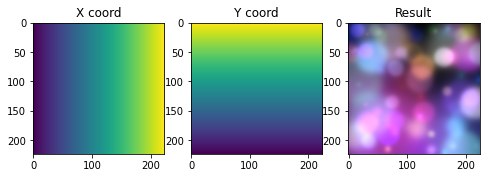

In [ ]:
# @title A custom class to draw some blobs of colour
class Dots(nn.Module):
  def __init__(self, n_points, w=224, h=224):
    super(Dots, self).__init__()

    # Set some attributes
    self.n_points = n_points
    self.w = w
    self.h = h
    self.sig = nn.Sigmoid()

    # A grid of x, y locations (from 0 to 1):
    gridy, gridx = torch.meshgrid(1-torch.arange(h)/h, torch.arange(w)/w)
    self.grid = torch.stack([gridx, gridy]).to(device) # shape: (2, w, h)

    # The parameters for the points:
    self.coords = torch.rand((2, n_points)).to(device) # X and Y positions
    self.sizes = torch.rand(n_points).to(device)*10 # << Tweak for bigger or smaller dots
    self.falloffs = (torch.rand(n_points).to(device)+0.2)*100 # << Tweak 0.2 and 100 to change look
    self.colors = torch.rand(3, n_points).to(device) # RGB colours
    self.intensities = torch.rand(n_points).to(device)*3 # << Change 3 to change max brightness

    # Set requires_grad on all of these parameters
    self.params = [self.coords, self.sizes, self.colors, self.falloffs, self.intensities]
    for p in self.params:
      p.requires_grad=True

    # The 'image' we'll draw to - RGB, same size as grid (w x h)
    self.canvas = torch.zeros_like(self.grid[0].expand(3, -1, -1)).to(device)

  def forward(self):
    self.canvas = torch.zeros_like(self.canvas) # Zero out our canvas
    for i in range(self.n_points): # Iterating over points (not ideal)
      # Point attributes:
      r, g, b = self.colors[:,i]
      intensity = self.intensities[i]
      px, py = self.coords[:,i]
      size = self.sizes[i]
      falloff = self.falloffs[i]

      # Distance from each pixel to this point:
      dx, dy = torch.abs(self.grid[0]-px), torch.abs(self.grid[1]-py)
      dist = (dx**2 + dy**2)**0.5

      # Draw the point with intensity dropping as distance increases
      sig_dist = 1-self.sig(dist*falloff - size)
      self.canvas[0] += r*sig_dist*intensity
      self.canvas[1] += g*sig_dist*intensity
      self.canvas[2] += b*sig_dist*intensity

    return self.canvas/(0.5*self.n_points**0.5) # Scale the final result (this is approximate) 

  def im_arr(self): # A convenience functuon to get the image as an array
    canvas = self.forward()
    return canvas.detach().cpu().permute(1, 2, 0).clip(0, 1)

# Create one with 100 blobs
d = Dots(100)

# Show the x and y grids and the output:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))
axs[0].imshow(d.grid[0].cpu())
axs[0].set_title('X coord')
axs[1].imshow(d.grid[1].cpu())
axs[1].set_title('Y coord')
axs[2].imshow(d.im_arr())
axs[2].set_title('Result')
plt.show()

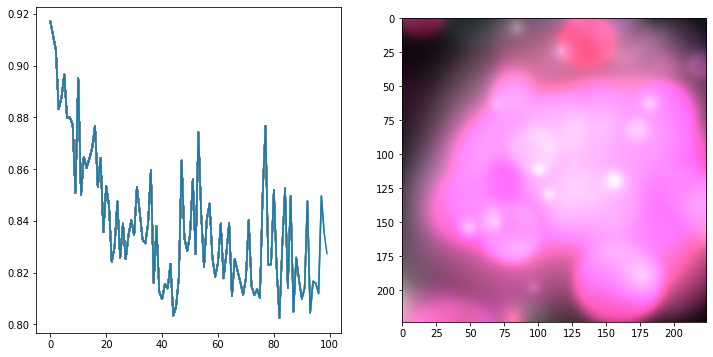

In [ ]:
#@title optimization loop

# The text target
text_prompt = "A pink jellyfish" #@param
text_embed = perceptor.encode_text(clip.tokenize(text_prompt).to(device)).float()

# Our Dots
d = Dots(200)

tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

# An optimizer (you can try others) with the image layers as parameters
optimizer = torch.optim.Adam(d.params, lr=0.03)

# Somewhere to track our losses
losses = []

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
p = display(fig,display_id=True)

# Losses plot
axs[0].plot(losses)

# Image preview
img = d.im_arr()
axs[1].imshow(img)

for i in range(100):
  optimizer.zero_grad()
  im = d().unsqueeze(0).clip(0, 1) 
  im_embed = perceptor.encode_image(normalize(tfms(im))).float()
  l = clip_loss(im_embed, text_embed)
  losses.append(float(l.detach().cpu())) # Store loss
  l.backward() # Backprop
  optimizer.step() # Update

  if i % 1 == 0:
    axs[0].plot(losses)
    axs[1].imshow(im.squeeze().permute(1, 2, 0).detach().cpu().clip(0, 1))
    p.update(fig)

ipd.clear_output()

I'm not wild about this partcular implementation, but it gets the point across: you can turn just about anything into an image. Check out the work @remi has been doing in the discord layering gabor filters or sinusoids to make images. 

I did take this sparkle thing a little further and get some nicer results: https://www.hicetnunc.xyz/sparkles_jw

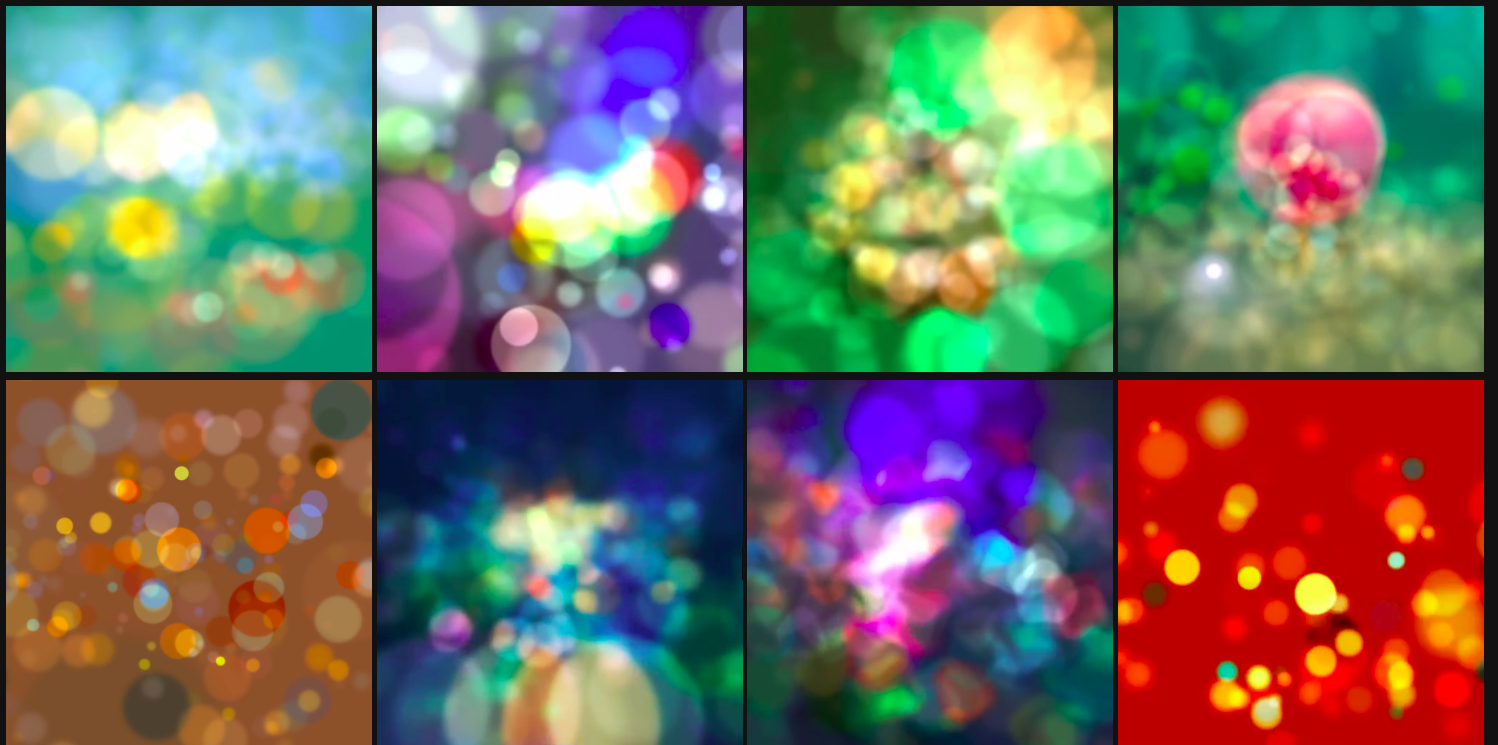

# Targeting successive prompts sequentially

I've duplicated the zooming GAN code from the first section here, with one small addition:

```
  if i == 100:
    text_embed = perceptor.encode_text(clip.tokenize("A live volcano, fiery lava painting").to(device)).float()
  if i == 200:
    text_embed = perceptor.encode_text(clip.tokenize("An ocean with waves, peaceful blue and green").to(device)).float()
```





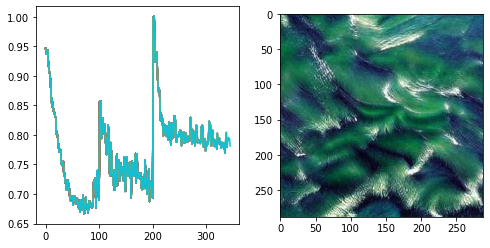

In [ ]:
#@title Zooming in and changing prompts:

prompt_text = "A vortex of blue fire and lightning, dramatic oil painting" #@param
transform_every =  5#@param
zoom =  8#@param
rotate = -1 #@param
start_transforms = 80 #@param
width = 300 #@param
height = 300 #@param
lr = 0.1 #@param
n_iter = 350 #@param
crops_per_iteration = 8 #@param

# The transforms to get variations of our image
tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

# The z we'll be optimizing
z = rand_z(width, height)
z.requires_grad=True

# The text target
text_embed = perceptor.encode_text(clip.tokenize(prompt_text).to(device)).float()

# The optimizer - feel free to try different ones here
optimizer = torch.optim.Adam([z], lr=lr, weight_decay=1e-6)

losses = [] # Keep track of our losses (RMSE values)

# A folder to save results
!rm -r steps
!mkdir steps


# Display for showing progress
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
p = display(fig, display_id=True)

# The optimization loop:
for i in tqdm(range(n_iter)):

  # Reset everything related to gradient calculations
  optimizer.zero_grad()

  # Get the GAN output
  output = synth(z)

  # Calculate our loss across several different random crops/transforms
  loss = 0
  for _ in range(crops_per_iteration):
    image_embed = perceptor.encode_image(tfms(normalize(output)).to(device)).float()
    loss += clip_loss(image_embed, text_embed)/crops_per_iteration

  # Store loss
  losses.append(loss.detach().item())

  # Backpropagate the loss and use it to update the parameters
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update

  # Update plots and save image
  if i % transform_every == 0:
    # Get image as array
    im_arr = np.array(output.cpu().squeeze().detach().permute(1, 2, 0)*255).astype(np.uint8)

    # Update plots
    axs[0].plot(losses)
    axs[1].imshow(im_arr)
    p.update(fig)

    # Save image
    Image.fromarray(im_arr).save(f'steps/{i//transform_every:04}.jpeg')


  if i > start_transforms and i%transform_every==0:
    # Apply some transforms
    im_arr = np.array(output.cpu().squeeze().detach().permute(1, 2, 0)*255).astype(np.uint8)
    pil_image = Image.fromarray(im_arr)
    sideX, sideY = pil_image.size
    im1 = pil_image.resize((sideX+zoom, sideY+zoom), Image.LANCZOS) # Zoom by adding zoom extra pixels
    im1 = im1.rotate(rotate) # Rotate by rotate degrees
    pil_image.paste(im1, (-zoom//2, -zoom//2)) # Paste this back over the original image

    # Re-encode this back into a new z to work with
    with torch.no_grad():
      z, *_ = model.encode(torch.tensor(np.array(pil_image)/255., dtype=torch.float).permute(2, 0, 1).unsqueeze(0).to(device) * 2 - 1)
      z.requires_grad = True
      optimizer = torch.optim.Adam([z], lr=lr, weight_decay=1e-6)

  if i == 100:
    text_embed = perceptor.encode_text(clip.tokenize("A live volcano, fiery lava painting").to(device)).float()
  if i == 200:
    text_embed = perceptor.encode_text(clip.tokenize("An ocean with waves, peaceful blue and green").to(device)).float()


ipd.clear_output()

In [ ]:
#@title Show Video
!ffmpeg -v 0 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v h264_nvenc -preset slow -qp 18 -pix_fmt yuv420p progress_video.mp4
from IPython.display import HTML
from base64 import b64encode
mp4 = open('progress_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=300 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

此单元格的输出内容太大，只能在登录的情况下显示。


This works fine - the generated image goes from looking like the initial prompt to looking like lava to looking like waves. However, the transitions can be quite fast. You can instead experiment with trying something along the lines of:


```
prompt1 = ...
prompt2 = ...

for i in range(100):
  ...
  loss = i/100 * clip_loss(prompt1...)
  loss += (1-i/100) * clip_loss(prompt2...)
```

This should let you move more slowly move between targets. You can even go crazy with easing functions, mixing in different prompts at different times etc etc. 

# Working with Video

![video camera GIF](https://c.tenor.com/xU5o4oSq-aIAAAAM/cop-watch-camera-man.gif)

We've made videos by transforming the output of VQGAN and feeding it back in as the starting point for the next iteration. But what if we want to working with actual video? Can we somehow use the frames of a video to guide our generation and create moving pieces? 

Let's try a few approaches. Note: this is very code-heavy, so I've tried to emphasize the places where changes have been made or key ideas are introduced.

First step: get a video and break it into individual frames. I'm using one from https://www.pexels.com/video/dog-running-on-riverside-5469175/ but you can upload your own.

In [ ]:
!mkdir -p frames
!ffmpeg -v 1 -i /content/dog_running.mp4 frames/%04d.jpeg
frames = sorted(glob.glob('frames/*.jpeg'))
print(len(frames))

250


In [ ]:
# We have a list of frames:
frames[:3] # Show the first 3

['frames/0001.jpeg', 'frames/0002.jpeg', 'frames/0003.jpeg']

You could run VQGAN with a CLIP prompt using each frame as the init image one by one. The results tend to be very flickery but the results can be pretty cool. Example (with notebook): https://twitter.com/artificial_art_/status/1449003191299883024?s=20

Downsides:
- Time consuming
- Flicker

What if we continually optimize our z but switch out different frames as a content loss target? Spoiler: also hard. We can try both of these approaches here:

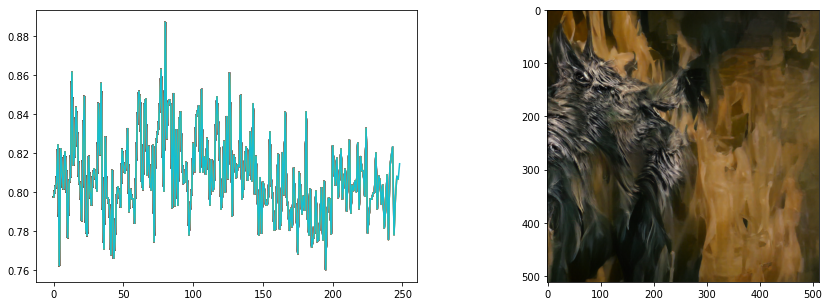

In [ ]:
advance_every = 5 #@param

!rm -r steps
!mkdir steps

size=512 #@param
prompt_text = 'A scary painting of a wolf in the night, oil on canvas artstation HD' #@param
text_embed = perceptor.encode_text(clip.tokenize(prompt_text).to(device)).float()
lr=0.15 #@param
iter_per_frame=10 #@param

content_weight =  0 #@param
clip_weight =  1 #@param

# The z we'll be optimizing
pil_image = Image.open(frames[0]).convert('RGB').resize((size, size), Image.LANCZOS)
z, *_ = model.encode(pil_to_torch(pil_image).to(device) * 2 - 1)
z.requires_grad=True

optimizer = torch.optim.AdamW([z], lr=lr, weight_decay=1e-6)
losses = [] # Keep track of our losses (RMSE values)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
p = display(fig,display_id=True)
for i, frame in enumerate(frames): # For each frame

  # Set the current frame as the content target
  content_image = Image.open(frame).resize((size, size))
  content_image_tensor = pil_to_torch(content_image).to(device)
  target_content_features = contentExtractor(content_image_tensor)

  # Uncomment to start each frame from scratch:
  pil_image = Image.open(frame).convert('RGB').resize((size, size), Image.LANCZOS)
  z, *_ = model.encode(pil_to_torch(pil_image).to(device) * 2 - 1)
  z.requires_grad=True
  optimizer = torch.optim.AdamW([z], lr=lr, weight_decay=1e-6)

  # Some number of iterations per frame
  for iter in range(iter_per_frame):
    optimizer.zero_grad()
    # Get the GAN output
    output = synth(z)

    # Calculate our CLIP loss across several different random crops/transforms
    loss = 0
    for _ in range(8):
      image_embed = perceptor.encode_image(tfms(normalize(output)).to(device)).float()
      loss += clip_loss(image_embed, text_embed)/8

    # Content  loss
    im_content_features = contentExtractor(output)
    loss += content_weight*content_loss(im_content_features, target_content_features)
    
    # Update Z
    loss.backward() # This does all the gradient calculations
    optimizer.step() # The optimizer does the update

  # Display and save
  with torch.no_grad():
    im = synth(z)
    im_arr = np.array(output.cpu().squeeze().detach().permute(1, 2, 0)*255).astype(np.uint8)
    axs[0].plot(losses)
    axs[1].imshow(im_arr)
    p.update(fig)
    Image.fromarray(im_arr).save(f'steps/{i:04}.jpeg')
  losses.append(loss.detach().item())
  

ipd.clear_output(wait=True)

In [ ]:
#@title Show Video
!ffmpeg -v 0 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v h264_nvenc -preset slow -qp 18 -pix_fmt yuv420p progress_video.mp4
from IPython.display import HTML
from base64 import b64encode
mp4 = open('progress_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=300 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

此单元格的输出内容太大，只能在登录的情况下显示。


What if, instead, we could somehow warp the previous generated frame based on the motion in the video?

Enter optical flow. You can read a decent introduction here: https://nanonets.com/blog/optical-flow/

We'll try to estimate how each pixel in the input video is moving frame-to-frame and use this to warp our generated image in the same way before starting on the next frame. 

Combined with a content target this can give some decent results for styling video (although colours can be hard to maintain and you'll still get flicker). 

Remove any sort of content target and just let the optical flow do it's thing for really wild effects!

Here's a function to warp an input image based on two video frames using PIL and openCV:


In [ ]:
def warp_pil_w_of(im, f1, f2, i=-1, of_sf=1):
  f1 = np.array(Image.open(f1).resize(im.size))
  f2 = np.array(Image.open(f2).resize(im.size))
  prev_gray = cv2.cvtColor(f1, cv2.COLOR_RGB2GRAY)
  cur_gray  = cv2.cvtColor(f2, cv2.COLOR_RGB2GRAY)
  # Calculate Optical Flow
  # flow = cv2.optflow.calcOpticalFlowSparseToDense(f1, f2, None) # Another option
  flow = cv2.calcOpticalFlowFarneback(prev=prev_gray,
                                      next=cur_gray, flow=None,
                                      pyr_scale=0.8, levels=15, winsize=15,
                                      iterations=10, poly_n=5, poly_sigma=0,
                                      flags=10)
  h, w = flow.shape[:2]
  flow = -1 * flow * of_sf
  flow[:,:,0] += np.arange(w)
  flow[:,:,1] += np.arange(h)[:,np.newaxis]
  warped = cv2.remap(np.array(im), flow, None, cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
  w =  np.array(warped[:,:,[2, 0, 1]])
  mask_bw = np.where(np.all(np.array(w)==[231, 230, 227],axis=2), 1, 0)
  mask = np.stack([mask_bw, mask_bw, mask_bw], axis=-1)
  result = np.array(im)*mask + w*(1-mask)
  final_im = Image.fromarray(result.astype(np.uint8))
  return final_im

With this in hand, we can generate frame by frame as before but with this key addition:

Before moving on the the next frame, we warp our image, re-encode it and use that as the starting point for the next frame:

```
pil_image = Image.fromarray(im_arr)
warped_im = warp_pil_w_of(pil_image, frames[i], frames[i+1])
z, *_ = model.encode(pil_to_torch(warped_im).to(device) * 2 - 1)
z.requires_grad=True
optimizer = torch.optim.AdamW([z], lr=lr, weight_decay=1e-6)
```

Play with this and let's see what we get!


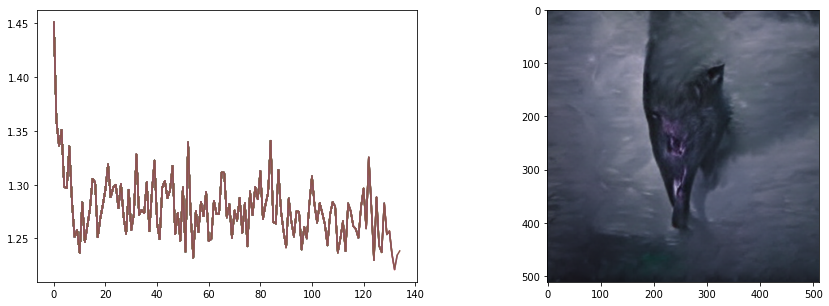

In [ ]:
advance_every = 5 #@param

!rm -r steps
!mkdir steps

size=512 #@param
prompt_text = 'A scary painting of a wolf in the night, oil on canvas artstation HD' #@param
text_embed = perceptor.encode_text(clip.tokenize(prompt_text).to(device)).float()
lr=0.15 #@param
iter_per_frame=5 #@param

content_weight =   0.5#@param
clip_weight =  1 #@param

# The z we'll be optimizing
pil_image = Image.open(frames[0]).convert('RGB').resize((size, size), Image.LANCZOS)
z, *_ = model.encode(pil_to_torch(pil_image).to(device) * 2 - 1)
z.requires_grad=True

optimizer = torch.optim.AdamW([z], lr=lr, weight_decay=1e-6)
losses = [] # Keep track of our losses (RMSE values)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
p = display(fig,display_id=True)
for i, frame in enumerate(frames): # For each frame

  # Set the current frame as the content target
  content_image = Image.open(frame).resize((size, size))
  content_image_tensor = pil_to_torch(content_image).to(device)
  target_content_features = contentExtractor(content_image_tensor)

  for iter in range(iter_per_frame):
    optimizer.zero_grad()
    # Get the GAN output
    output = synth(z)

    # Calculate our CLIP loss across several different random crops/transforms
    loss = 0
    for _ in range(8):
      image_embed = perceptor.encode_image(tfms(normalize(output)).to(device)).float()
      loss += clip_loss(image_embed, text_embed)/8

    # Content  loss
    im_content_features = contentExtractor(output)
    loss += content_weight*content_loss(im_content_features, target_content_features)
    
    # Update Z
    loss.backward() # This does all the gradient calculations
    optimizer.step() # The optimizer does the update

  # Display and save
  with torch.no_grad():
    im = synth(z)
    im_arr = np.array(output.cpu().squeeze().detach().permute(1, 2, 0)*255).astype(np.uint8)
    axs[0].plot(losses)
    axs[1].imshow(im_arr)
    p.update(fig)
    Image.fromarray(im_arr).save(f'steps/{i:04}.jpeg')

    # Warp the image and re-encode to give a starting point for the next frame:
    if i < len(frames)-1:
      pil_image = Image.fromarray(im_arr)
      warped_im = warp_pil_w_of(pil_image, frames[i], frames[i+1])
      z, *_ = model.encode(pil_to_torch(warped_im).to(device) * 2 - 1)
      z.requires_grad=True
      optimizer = torch.optim.AdamW([z], lr=lr, weight_decay=1e-6)

  losses.append(loss.detach().item())
  

ipd.clear_output(wait=True)

You may hit memory issues running this multiple times. This can be fixed by restarting and running just the setup section again, but before that try the following to free up a little memory:

In [ ]:
del z
del text_embed
del loss
del optimizer
torch.cuda.empty_cache()

Video is much harder to get right than image generation. But you can get some really cool effects with a bit of effort. Here's a gallery of some that I've made: https://www.hicetnunc.art/flow_jw/creations

Some ways to get better results:
- Store the intermediate zs and interpolate smoothly between them to render out a less jittery version of the video

- Re-colour the generated video in post

- Tweak parameters... a lot


# What else?

![toolbox GIF](https://i.gifer.com/origin/5a/5a5621f8dec302572c8a8791ef095752_w200.gif)

You should now have a toolbox of ideas for ways to make art with AI. What other ideas do you have? Let's explore this space together over the coming weeks :)

See you in the Discord,

-J
